# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

# Processing the Dataset

In [3]:
alin_path = ''
gourab_path = '/content/drive/MyDrive/archive/'
path = gourab_path

In [4]:
path1 = path + 'Fish_Dataset/Fish_Dataset/'

In [5]:
folder_list = [x for x in os.listdir(path1) if '.' not in x]
folder_list

['Red Sea Bream',
 'Gilt-Head Bream',
 'Red Mullet',
 'Hourse Mackerel',
 'Striped Red Mullet',
 'Shrimp',
 'Trout',
 'Sea Bass',
 'Black Sea Sprat']

In [6]:
ds = []
for n,x in enumerate(folder_list):
    for i in os.listdir(path1+'/'+x+'/'+x):
        ds.append([path1+'/'+x+'/'+x+'/'+i,n,x])
df = pd.DataFrame(ds,columns=['Path','Label','Name'])
df.to_csv('/content/drive/MyDrive/archive/dataset.csv')

In [7]:
df.Name.unique()

array(['Red Sea Bream', 'Gilt-Head Bream', 'Red Mullet',
       'Hourse Mackerel', 'Striped Red Mullet', 'Shrimp', 'Trout',
       'Sea Bass', 'Black Sea Sprat'], dtype=object)

In [8]:
classes = df.Name.value_counts().index
classes

Index(['Red Sea Bream', 'Gilt-Head Bream', 'Red Mullet', 'Hourse Mackerel',
       'Striped Red Mullet', 'Shrimp', 'Trout', 'Sea Bass', 'Black Sea Sprat'],
      dtype='object')

# Visualizing the Dataset and Relevant Informations

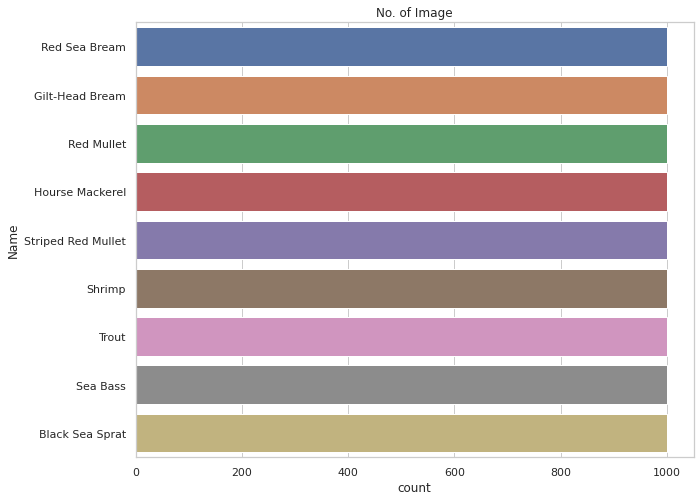

In [9]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,8))
ax = sns.countplot(y=df.Name)
ax.set_title('No. of Image');

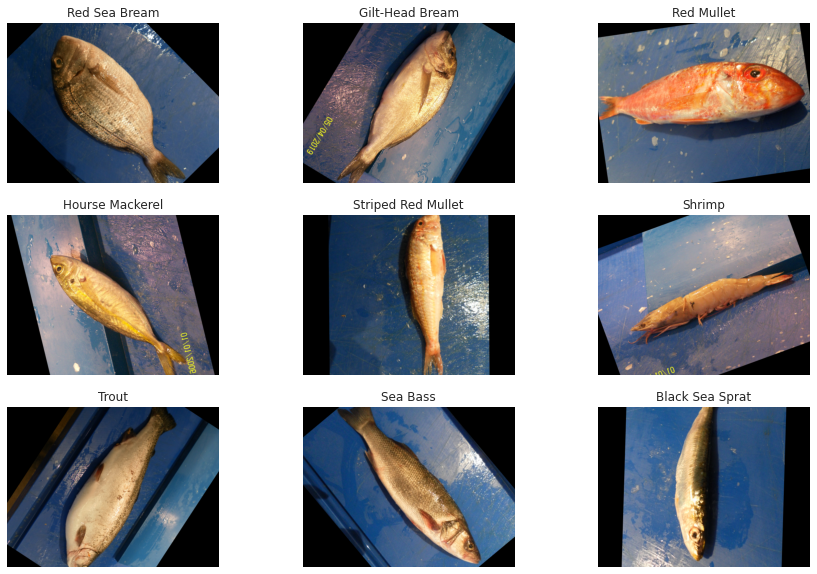

In [10]:
import random
fig, axs = plt.subplots(3,3,figsize=(15,10))
for i,x in enumerate(df.Name.value_counts().index):
    img = plt.imread(random.choice(df.loc[df.Name==df.Name.value_counts().index[i]].Path.to_list()))
    axs[int((i-i%3)/3),i%3].imshow(img)
    axs[int((i-i%3)/3),i%3].axis('off')
    axs[int((i-i%3)/3),i%3].set_title(x)

# Helper Functions

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((df.Path,df.Label))
def get_train_val_test_split(ds,shuffle : bool = True,shuffle_size : int =5000):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*.8)
    val_size=int(ds_size*.1)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_train_val_test_split(dataset)

In [12]:
def load_images(filename,label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,(224,224))
    return image,label
def augment(image,label):
    image = tf.image.random_brightness(image,max_delta=.2)
    image = tf.image.random_flip_left_right(image)
    iamge = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image)
    image = tf.image.stateless_random_jpeg_quality(image,min_jpeg_quality=90,
                                                  max_jpeg_quality=100,
                                                  seed=(np.random.randint(100),
                                                       np.random.randint(100)))
    return image,label

In [13]:
BATCH_SIZE=32
train_ds = (train_ds
          .shuffle(len(train_ds)*100,seed=42)
          .map(load_images)
          .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
          .cache()
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))
test_ds =(test_ds
         .shuffle(len(test_ds)*100)
         .map(load_images)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))
val_ds =(val_ds
         .shuffle(len(test_ds)*100)
         .map(load_images)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))
batch = next(iter(train_ds))

# Model Related Functions

In [14]:
def build_model(model_url):
    feature_extractor_layer = hub.KerasLayer(model_url,
                                        trainable=False,
                                        name='feature_extraction_layer',
                                        input_shape=(224,224,3))
    
    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(9,activation='softmax')
    ])

    return model


In [15]:
def train_model(model, training_set, validation_set, epochs):
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                                  patience=3,
                                                                  verbose=1,
                                                                  factor=.5,
                                                                  min_lr=.00001)
    
    history = model.fit(training_set,
                 epochs=epochs,
                 validation_data=validation_set,
                 callbacks=[learning_rate_reduction])
    
    return history

# Performance Functions

In [16]:
def plot_history(history):
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    history_data = pd.DataFrame(history.history)
    sns.lineplot(data=history_data[['loss','val_loss']],ax=ax[0])
    sns.lineplot(data=history_data[['accuracy','val_accuracy']],ax=ax[1])
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs');

In [17]:
from sklearn.metrics import classification_report
def get_report(model, test_set):
    test_data = [label.numpy() for example, label in test_set]
    y_test = np.concatenate(np.array(test_data))
    y_test_class = [classes[x] for x in y_test]
    y_pred = tf.argmax(model.predict(test_set),axis=1)
    y_pred_class = [classes[x] for x in y_pred]
    print(classification_report(y_test_class,y_pred_class))

In [67]:
mobilenet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5' # epoch = 20, lr = 0.001
inception_net_url = 'https://tfhub.dev/google/imagenet/inception_v3/classification/5' # epoch = 20, lr = 0.001
resnet50_url = 'https://tfhub.dev/tensorflow/resnet_50/classification/1' # epoch = 100, lr = 0.05
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/classification/1' # epoch = 20, lr = 0.01
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2' # epoch = 20, lr = 0.001
vision_transformer = 'https://tfhub.dev/sayakpaul/vit_b16_classification/1' # epoch = 7 lr = 0.001
bit_url = 'https://tfhub.dev/google/bit/s-r101x3/ilsvrc2012_classification/1' # epoch = 7 lr = 0.001


url = vision_transformer

model = build_model(url)

optimizer = keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

history = train_model(model, train_ds, val_ds, epochs=7)


Epoch 1/7
225/225 [==============================] - 61s 239ms/step - loss: 0.1917 - accuracy: 0.9514 - val_loss: 0.0334 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 2/7
225/225 [==============================] - 48s 212ms/step - loss: 0.0145 - accuracy: 0.9990 - val_loss: 0.0240 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 3/7
225/225 [==============================] - 48s 212ms/step - loss: 0.0072 - accuracy: 0.9997 - val_loss: 0.0184 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 4/7
225/225 [==============================] - 48s 212ms/step - loss: 0.0045 - accuracy: 0.9999 - val_loss: 0.0153 - val_accuracy: 0.9956 - lr: 0.0010
Epoch 5/7
225/225 [==============================] - 48s 212ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0136 - val_accuracy: 0.9956 - lr: 0.0010
Epoch 6/7
225/225 [==============================] - 48s 212ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0127 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 7/7
225/225 [==============================] - 48s 2

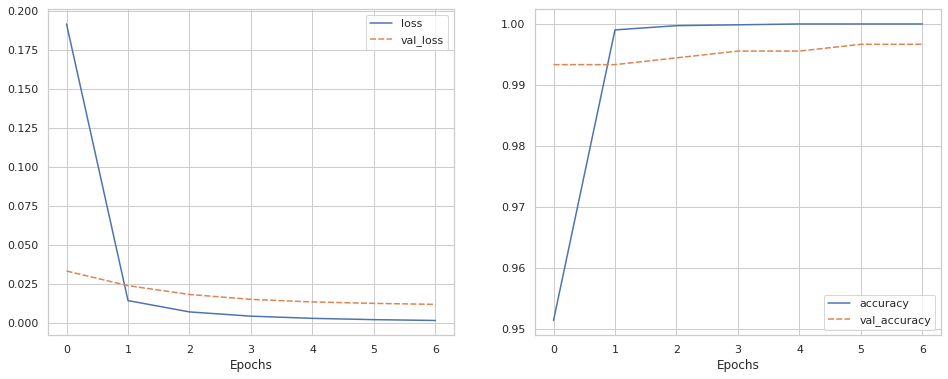

In [68]:
plot_history(history)

In [69]:
get_report(model, test_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       156
   Gilt-Head Bream       1.00      0.97      0.98        90
   Hourse Mackerel       1.00      0.99      0.99        79
        Red Mullet       1.00      1.00      1.00        88
     Red Sea Bream       0.97      1.00      0.98        91
          Sea Bass       1.00      1.00      1.00       132
            Shrimp       1.00      1.00      1.00        90
Striped Red Mullet       0.99      1.00      0.99        70
             Trout       1.00      1.00      1.00       104

          accuracy                           1.00       900
         macro avg       0.99      0.99      0.99       900
      weighted avg       1.00      1.00      1.00       900

